In [3]:
import os
import warnings

warnings.filterwarnings('ignore')

import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
print(os.listdir("../results/samples"))

train_path = "../results/samples/train/"
valid_path = "../results/samples/validation/"
test_path = "../results/samples/test/"

['validation', 'test', 'train']


In [5]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset

import numpy as np
 
# class that defines and loads the dataset
# Dataset is a parent!!!
class GetDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_name, pathname, num_of_images = -1):
        
        # 1 == the number of classes (not including background), 
        # dataset_name is to help keep track of what the instance of the
        # class is holding. In this case it's "sand_dollar"
        self.add_class('dataset', 1, 'sand dollar')
        
        # Goes through all of the folder, records the basename of each file
        # then knowing that each the filenames are the same, just concats the suffix
        # to the basename, then appends each to their respective arrays
        
        # !!! Change to use glob instead of os !!!
        
        count = 0
        
        for file in os.listdir(pathname):
            
            # makes it so that we only loop through once and twice (i.e. creating duplicates)
            if(".orig.xml" in file):

                filename = file.split(".orig")[0]
                image_ids = filename

                xml_path = pathname + filename + ".orig.xml"

                image_path = pathname + filename + ".orig.jpg"
                
                self.add_image('dataset', image_id = image_ids, path = image_path, annotation = xml_path) 
                
                count += 1
                
                if(count == num_of_images):
                    break
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        
        # get details of image
        info = self.image_info[image_id]
        
        # define box file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('sand dollar'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [6]:
# train set
train_set = GetDataset()
train_set.load_dataset('sand dollar train', train_path, num_of_images = 25)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# val set
val_set = GetDataset()
val_set.load_dataset('sand dollar validation', valid_path)
val_set.prepare()
print('Valid: %d' % len(val_set.image_ids))

# test set
test_set = GetDataset()
test_set.load_dataset('sand dollar test', test_path)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 25
Valid: 20
Test: 61


In [7]:
# Just a display of a image and a annotation
import matplotlib.pyplot as plt

index = np.random.randint(len(train_set.image_ids))

image = train_set.load_image(index)
print(image.shape)

# load image mask
mask, class_ids = train_set.load_mask(index)
print(mask.shape)

# plot image
plt.imshow(image)

# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

(1024, 1360, 3)
(1024, 1360, 5)


<Figure size 640x480 with 1 Axes>

In [8]:
# Gives a view of what's going on in the object we created
def sanity_check(dataset):
    for image_id in dataset.image_ids:
        # load image info
        info = dataset.image_info[image_id]
        # display on the console
        print(info)
        
#sanity_check(train_set)

../results/samples/train/201503.20150602.121650472.69153.orig.jpg
Number of annotations: 94


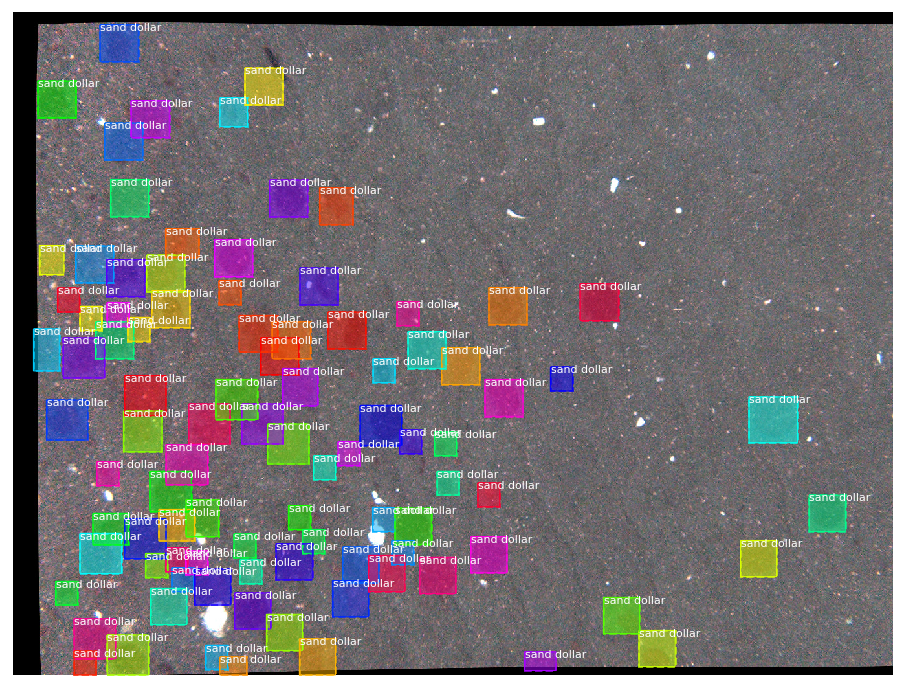

In [9]:
# Provides a better display of a image, and ALL of the annotations for said image
# takes a bit of time, blame the original repo, but at least it's pretty :)

from Mask_RCNN.mrcnn.visualize import display_instances
from Mask_RCNN.mrcnn.utils import extract_bboxes
# in visualize.py, change line 28 to "from Mask_RCNN.mrcnn import utils" :)

# define image id
index = 5

print(train_set.image_reference(index))

# load the image
image = train_set.load_image(index)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(index)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)

print("Number of annotations:", mask.shape[2])
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [10]:
from Mask_RCNN.mrcnn.config import Config

# define a configuration for the training process
# can change the configure file, see the original
# MaskRCNN repo for details about different hyperparameters!

# Will need everyone's help figuring out the hyperparameters!
class TrainConfig(Config):
   
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    IMAGES_PER_GPU = 1
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
    
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128
    
    LEARNING_RATE = .0001          
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    
    
training_config = TrainConfig()

In [12]:
from Mask_RCNN.mrcnn.model import MaskRCNN
# Change line 29 in model.py to "from Mask_RCNN.mrcnn import utils"

training_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

image_id:  ../results/samples/train/201503.20150602.121650472.69153.orig.jpg
Original shape:  (1024, 1360, 3)
New shape: (1024, 1024, 3)


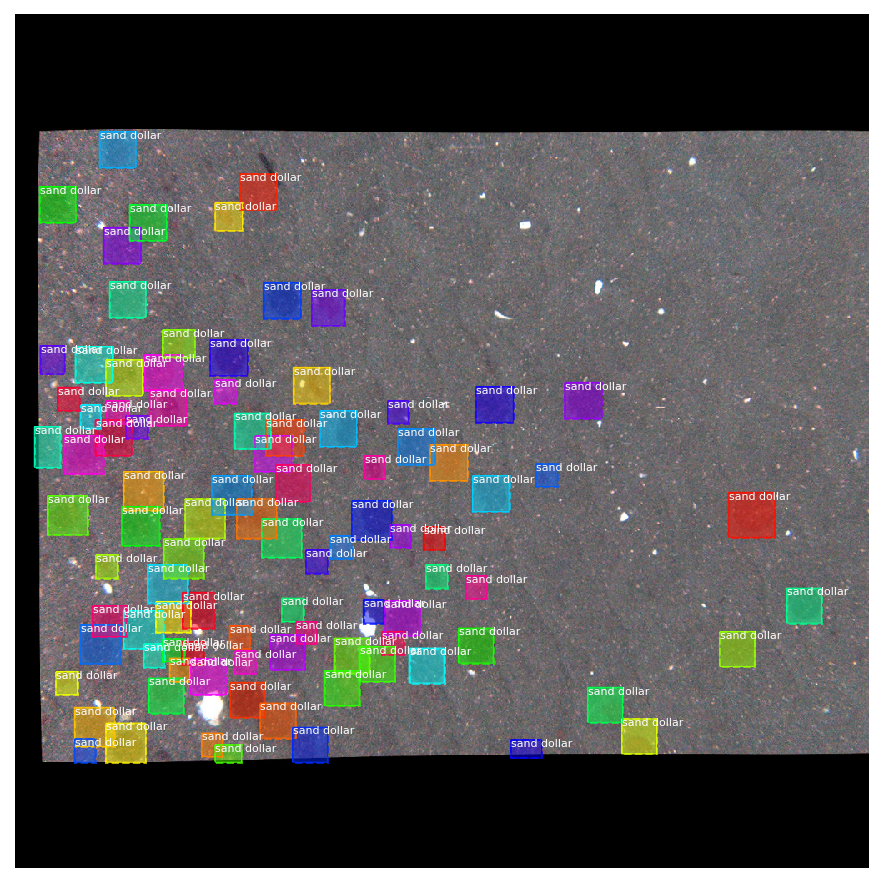

In [13]:
# Resizing training images and mask based on the details in the config file
from Mask_RCNN.mrcnn import utils, visualize

image = train_set.load_image(index)
mask, class_ids = train_set.load_mask(index)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(image, min_dim=training_config.IMAGE_MIN_DIM, max_dim=training_config.IMAGE_MAX_DIM)

mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)


# Display image and additional stats
print("image_id: ", train_set.image_reference(index))
print("Original shape: ", original_shape)
print("New shape:", image.shape)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
# define the model
model = MaskRCNN(mode='training', model_dir='./eventlogs', config=training_config)

# load weights (mscoco) and exclude the output layers
model.load_weights('./mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, val_set, learning_rate=training_config.LEARNING_RATE, epochs = 10, layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: ./eventlogs/sand_dollar_config20190829T2217/mask_rcnn_sand_dollar_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


In [22]:
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from Mask_RCNN.mrcnn.utils import compute_ap
from Mask_RCNN.mrcnn.model import load_image_gt
from Mask_RCNN.mrcnn.model import mold_image

# define the prediction configuration, very similar to the train config as above
class TestConfig(Config):
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels
    
    # resizing image options
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
 


In [23]:
testing_config = TestConfig()

testing_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [24]:
# calculate the mAP for a model on a given dataset 
# (taken directly from kangaroo tutorial)
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        
        # convert pixel values (e.g. center)
        # essentially preprocessing the images to match
        # the format the images were when we used them
        # for training
        scaled_image = mold_image(image, cfg)
        
        # convert image into one sample
        # changes the dimensions to include the 
        # number of batches (which is one)
        sample = expand_dims(scaled_image, 0)
       
        # make prediction
        yhat = model.detect(sample, verbose=0)
        
        # extract results for first sample
        r = yhat[0]
        
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        # store
        APs.append(AP)
    
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [ ]:
model = MaskRCNN(mode = 'inference', model_dir = './eventlogs/', config = testing_config)

# load model weights that did the best (see the model training output and the epoch with the lowest validation loss scores).

# the weights save in a folder in the eventlogs so that needs to be manually typed in (different for each person)
model.load_weights('./eventlogs/sand_dollar_config20190829T0549/mask_rcnn_sand_dollar_config_0005.h5', by_name = True)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, testing_config)
print("Train mAP: %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, testing_config)
print("Test mAP: %.3f" % test_mAP)

In [30]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    
    plt.figure(figsize = (10, 45))
    # load image and mask
    for i in range(n_images):
        
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
            
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)

        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        
        #plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

In [ ]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, testing_config)

# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, testing_config)